In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

# Import Libraries
import dlib
import glob
import cv2
import os
import sys
import time
# import pyautogui as pyg
# import shutil

from PIL import Image

import json

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import dlib
from PIL import Image

import face_alignment
from skimage import io
import copy
import json
import time
import os
import pickle
import ffmpeg

from natsort import natsorted, ns

from scipy.signal import medfilt
from scipy.ndimage.filters import uniform_filter1d

## Load thermal images

In [3]:
def thr_load(img_dir, first_img=0, last_img=None, interval=1):
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'npy']
    
    filenames = natsorted(filenames, alg=ns.IGNORECASE)
#     filenames.sort()
        
    img_list = []
        
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
        
    for filename in filenames:
        img = np.load(img_dir + filename)
        img_list.append(img)    
        
    return filenames, img_list

In [4]:
thr_sel_dict = {'03': [1482,2082],
                '04': [12758,13358],
                '05': [16067,16667],
                '06': [20278,20878],
                '07': [12179,12779],
                '08': [13098,13698],
                '09': [14876,15476],
                '10': [16901,17501],
                '13': [2063,2663],
                '14': [20441,21041],
                '15': [4051,4651],
                '16': [3418,4018],
                '17': [2355,2955],
                '22': [7548,8148],
                '24': [10086,10686],
                '25': [1819,2419],
                '26': [352,952],
                '27': [8767,9367]}

In [5]:
p_list_all = list(thr_sel_dict.keys())
p_list_10 = ['03', '04', '05', '07', '08', '09', '13', '14', '15', '16', '17', '22', '25', '26', '27']

In [6]:
img_list_i30_all = []
for p in p_list_all:
    img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/npy/'
    first_img = thr_sel_dict[p][0]
    last_img = thr_sel_dict[p][1]
    filenames, img_list = thr_load(img_dir, first_img=first_img, last_img=last_img, interval=30)
    img_list_i30_all.append(img_list)

In [7]:
print(len(img_list_i30_all))
print(len(img_list_i30_all[0]))

18
20


## Load picked thermal landmarks

In [8]:
def json_load(json_dir):
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(json_dir) if f.split('.')[1] == 'json']
    filenames.sort()
    
    json_list = []
    
    for filename in filenames:
        json_path = json_dir + filename
        
        with open(json_path) as json_file:
            json_data = json.load(json_file)
            json_list.append(json_data)
        
    return filenames, json_list

def json2tuples(json_lmarks):
    landmark_tuples_thr = []
    for c in json_lmarks['shapes']:
        x = int(c['points'][0][0])
        y = int(c['points'][0][1])
        landmark_tuples_thr.append((x,y))
    return landmark_tuples_thr

def json2tuples_list(json_list):
    lmark_list = []
    for json_lmarks in json_list:
        lmarks = json2tuples(json_lmarks)
        lmark_list.append(lmarks)
    return lmark_list

In [9]:
lm_list_i30_all = []
for p in p_list_all:
    # load thermal landmark picks
    json_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/picks_sel/'
    json_fnames, json_list = json_load(json_dir)
    # convert landmarks to list of tuples
    thr_lmark_list = json2tuples_list(json_list)
    lm_list_i30_all.append(thr_lmark_list)

In [10]:
print(len(lm_list_i30_all))
print(len(lm_list_i30_all[0]))

18
20


In [11]:
img_list_i30_flat = [item for sublist in img_list_i30_all for item in sublist]
lm_list_i30_flat = [item for sublist in lm_list_i30_all for item in sublist]

In [12]:
print(len(img_list_i30_flat))
print(len(lm_list_i30_flat))
print(len(img_list_i30_flat[0]))
print(len(lm_list_i30_flat[0]))

360
360
256
10


## Opt quant

In [13]:
# output = optimal_quantization(mat, True)  
def optimal_quantization(t2d_data, print_mode = False):
    
    t2d_data_cp = copy.deepcopy(t2d_data)  
    
    vector_data= np.reshape(t2d_data_cp, t2d_data_cp.shape[0]*t2d_data_cp.shape[1])
    # select only values above zero when calculating min/max to avoid padding - sm
    vector_data = vector_data[vector_data > 0]
    
    min_T=np.percentile(vector_data, 2.5)  #2.5 percentile point
#     max_T=np.percentile(vector_data, 97.5) #97.5 percentile point
    
    # try a higher max_T - sm
    max_T=np.percentile(vector_data, 100) #99.5 percentile point
#     max_T = 36

    t2d_data_cp[np.where(t2d_data_cp > max_T)]=max_T
    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    opt_T=min_T
    count=0
    while True:
        count+=1
        mean_back=np.mean(t2d_data_cp[np.where(t2d_data_cp <= opt_T)])
        mean_obj=np.mean(t2d_data_cp[np.where(t2d_data_cp > opt_T)])
        if np.abs(opt_T - (mean_back+mean_obj)/2 )<0.005:
            break;
        else:
            opt_T=(mean_back+mean_obj)/2

    min_T=opt_T

    if print_mode:
        print("optimal thermal range is [%f, %f]"%(min_T,max_T))

    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    quantized_t_img=np.zeros((t2d_data_cp.shape[0],t2d_data_cp.shape[1]), np.uint8)

    for i in range(0, t2d_data_cp.shape[0]):
        for j in range(0, t2d_data_cp.shape[1]):
            quantized_t_img[i,j]=255*((t2d_data_cp[i,j]-min_T)/(max_T-min_T))

    return quantized_t_img 

In [14]:
def opt_quant_list(image_list, print_mode=False):
    new_image_list = []
    for i, img in enumerate(image_list):
        new_image = optimal_quantization(img, print_mode = print_mode)
        new_image_list.append(new_image)
    return new_image_list 

In [15]:
# Optimal quantisation
img_list_i30_oq = opt_quant_list(img_list_i30_flat)

In [16]:
# sel_list = [36,39,42,45,30,48,54,0,8,16]

## Landmarks to bboxes

In [17]:
def plot_landmarks2bbox(img_list, landmarks_list, img_no=0, margin=50):
    # copy image to avoid overwriting
    img = img_list[img_no].copy()
    # extract landmark tuples for image
    landmark_tuples = landmarks_list[img_no]
    # initialise min and max coords for edge of landmarks as first landmark
    min_x = landmark_tuples[0][0]
    max_x = landmark_tuples[0][0]
    min_y = landmark_tuples[0][1]
    max_y = landmark_tuples[0][1]
#     print(min_x, max_x, min_y, max_y)
    # loop through the selected landmarks (normally edge of jaw and top of both eyebrows)
    for lm in landmark_tuples:
        if lm[0] > max_x:
            max_x = lm[0]
        if lm[0] < min_x:
            min_x = lm[0]
        if lm[1] > max_y:
            max_y = lm[1]
        if lm[1] < min_y:
            min_y = lm[1]
#     print(min_x, max_x, min_y, max_y)
    # expand limits a by a margin to ensure rectangle contains full face
    start = (int(min_x-margin), int(min_y-margin))
    end = (int(max_x+margin), int(max_y+margin))
    # add rectangle to image
    cv2.rectangle(img, start, end, (255, 255, 0), 4)
    # plot image with rectangle    
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(img)
    plt.show()

In [18]:
len(img_list_i30_oq)

360

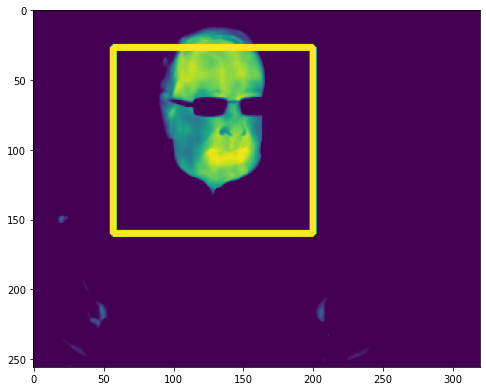

In [19]:
plot_landmarks2bbox(img_list_i30_oq, lm_list_i30_flat, img_no=0, margin=40)

In [20]:
def landmarks2bbox(landmarks_list, img_no=0, margin=40, square=False):
    # extract landmark tuples for image
    landmark_tuples = landmarks_list[img_no]
    # initialise min and max coords for edge of landmarks as first landmark
    min_x = landmark_tuples[0][0]
    max_x = landmark_tuples[0][0]
    min_y = landmark_tuples[0][1]
    max_y = landmark_tuples[0][1]
#     print(min_x, max_x, min_y, max_y)
    # loop through the selected landmarks (normally edge of jaw and top of both eyebrows)
    for lm in landmark_tuples:
        if lm[0] > max_x:
            max_x = lm[0]
        if lm[0] < min_x:
            min_x = lm[0]
        if lm[1] > max_y:
            max_y = lm[1]
        if lm[1] < min_y:
            min_y = lm[1]
    
    # expand limits a by a margin to ensure rectangle contains full face
    start = (int(min_x-margin), int(min_y-margin))
    end = (int(max_x+margin), int(max_y+margin))

    return [start,end]

In [21]:
def gen_bbox_list(landmarks_list):
    bbox_list = []
    for i, lms in enumerate(landmarks_list):
#         start_end = landmarks2bbox_square(landmarks_list, points=[0,8,16,19,24], img_no=i, margin=50)
        start_end = landmarks2bbox(landmarks_list, img_no=i, margin=40)
        bbox_list.append(start_end)
    return bbox_list

In [22]:
bbox_list = gen_bbox_list(lm_list_i30_flat)

In [23]:
# bbox_list

In [24]:
for bbox in bbox_list:
    if len(bbox) ==0:
        print(bbox)

In [25]:
def vis_bbox(img_list, bbox_list, first_img, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+8, nrows+8)) # create figure
#     plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            bbox_tuples = bbox_list[idx_plt+first_img]
            cv2.rectangle(img, bbox_tuples[0], bbox_tuples[1], (255, 255, 0), 4)
#             name_text = filenames_list[idx_plt+first_img].split('.')[0][10:]
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
#                 ax[idx_plt].set_title(name_text)
            else:
                ax[row][col].imshow(img)
#                 ax[row][col].set_title(name_text)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

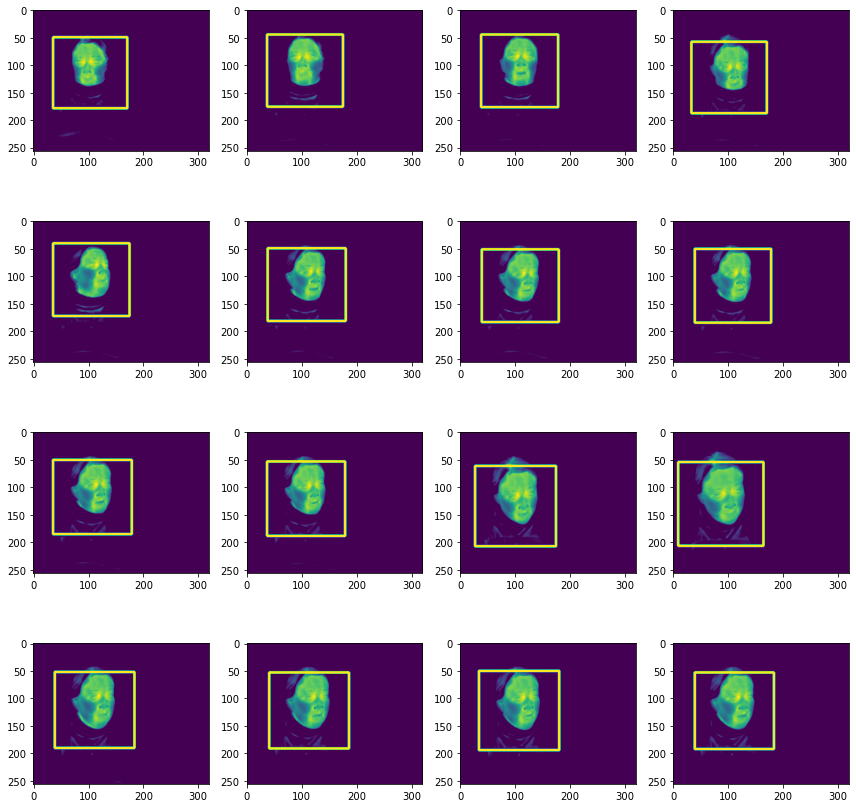

In [26]:
vis_bbox(img_list_i30_oq, bbox_list, first_img=40, nrows=4, ncols=4)

## additional plot for report

In [27]:
def vis_bbox_report(img_list, bbox_list, lm_list, idx_list, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+8, nrows+8)) # create figure
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_list[idx_plt]].copy()
            bbox_tuples = bbox_list[idx_list[idx_plt]]
            landmarks = lm_list[idx_list[idx_plt]]
            
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            
            cv2.rectangle(img, bbox_tuples[0], bbox_tuples[1], (0, 255, 0), 4)
            
            for n in range(0,10):
                    x=landmarks[n][0]
                    y=landmarks[n][1]
                    cv2.circle(img, (x, y), 1, (255, 0, 0), 2)
            
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img, cmap=plt.get_cmap('gray'))
                ax[idx_plt].axis('off')
            else:
                ax[row][col].imshow(img, cmap=plt.get_cmap('gray'))
                ax[row][col].axis('off')
            
            idx_plt+= 1
                
    plt.tight_layout()
    plot_name = 'bbox_examples.png'
    plt.savefig(plot_name)

    plt.show()

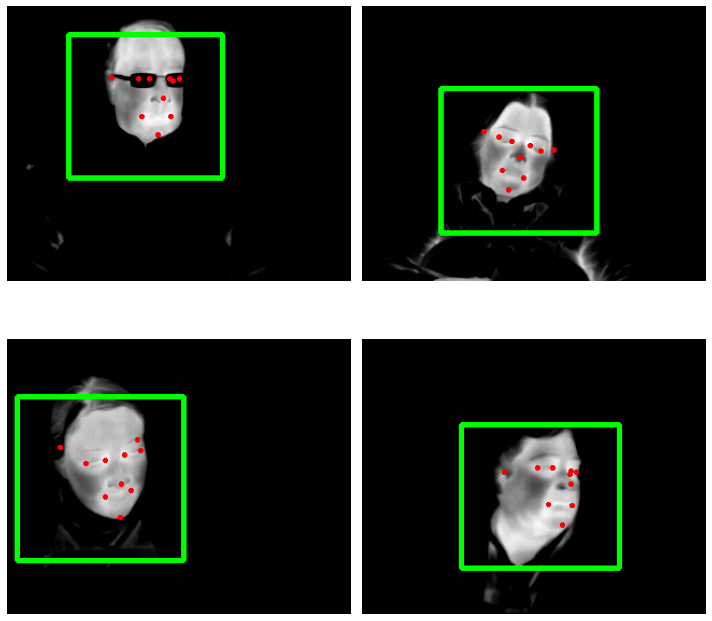

In [28]:
vis_bbox_report(img_list_i30_oq, bbox_list, lm_list_i30_flat, [0,20,51,281], nrows=2, ncols=2)

## Convert bboxes to dlib rectangles

In [29]:
def bbox2dlib(bbox):
    left = bbox[0][0]
    right = bbox[1][0]
    top = bbox[0][1]
    bottom = bbox[1][1]
    dlib_box = [dlib.rectangle(left=left , top=top, right=right, bottom=bottom)]
    return dlib_box

In [30]:
dlib_box_list = []
for bbox in bbox_list:
    dlib_box_list.append(bbox2dlib(bbox))

In [31]:
bbox_list[0]

[(57, 27), (200, 160)]

In [32]:
dlib_box_list[0]

[rectangle(57,27,200,160)]

In [33]:
# check rectangle correctly coded by checking area
temp = dlib_box_list[0][0]
temp.area()

19296

# Train face detector using images and dlib boxes

In [34]:
# Initialize object detector Options
options = dlib.simple_object_detector_training_options()

# I'm disabling the horizontal flipping, becauase it confuses the detector if you're training on few examples
# By doing this the detector will only detect left or right hand (whichever you trained on). 
options.add_left_right_image_flips = False

# Set the c parameter of SVM equal to 5
# A bigger C encourages the model to better fit the training data, it can lead to overfitting.
# So set an optimal C value via trail and error.
options.C = 5

# Note the start time before training.
st = time.time()

# You can start the training now
# detector = dlib.train_simple_object_detector(png_img_list[:1000], dlib_box_list[:1000], options)
detector = dlib.train_simple_object_detector(img_list_i30_oq, dlib_box_list, options)

# Print the Total time taken to train the detector
print('Training Completed, Total Time taken: {:.2f} seconds'.format(time.time() - st))

Training Completed, Total Time taken: 15.51 seconds


In [35]:
# save model
file_name = 'Bentley_Th_Head_Detector_v2.svm'
detector.save(file_name)